In [24]:
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

sys.path.append(r"C:\Users\pgrover\Documents\code\pymorph")
import weno_morph_model as wmm
import schemes.weno as weno
import numpy as np
from scipy.signal import savgol_filter
import sediment_transport.sed_trans as st
%load_ext cython
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('classic')

The cython extension is already loaded. To reload it, use:
  %reload_ext cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple Morphodynamic Modelling for Paper 2 - Queens Flume Study

In [8]:
geometry_folder = r'C:\Users\pgrover\Dropbox\PhD\Papers\Paper 2 - Roughness Turbulence LRN\FlumeExperiment\geometries'
bed_filepath = os.path.join(geometry_folder, 'flume_profile_smoothed_v002.txt')


D50 = 1.0/1000.
model = wmm.UpwindMorphologicalModel(D50)
zbed, xc, dx = wmm.load_bed_profile(bed_filepath)

['ncols', '4']
['nrows', '87']
['xllcorner', '0']
['yllcorner', '0']
['cellsize', '0.03']
['NODATA_value', '-9999']


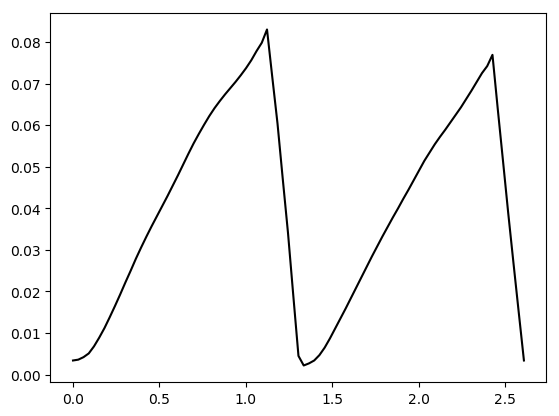

In [10]:
plt.plot(xc,zbed,'k-')

## Re-interpolate the profile

In [9]:
case_folder = r'C:\Data\PhD\LRN-WallTreatments-openFOAM-5.x\validation\QueensFlume'

bed_shear_filepath = os.path.join(case_folder,'32.cm', 'dune.127z.30r.colebrook.yp.0.x', '30', 'wallShearStress.txt')
bed_shear_stress = wmm.load_bed_shear_stress(bed_shear_filepath)


In [15]:
dune_length=xc.max()
xint = np.linspace(0, dune_length, len(bed_shear_stress))
zinterp = np.interp(xint, xc,zbed)




No handles with labels found to put in legend.


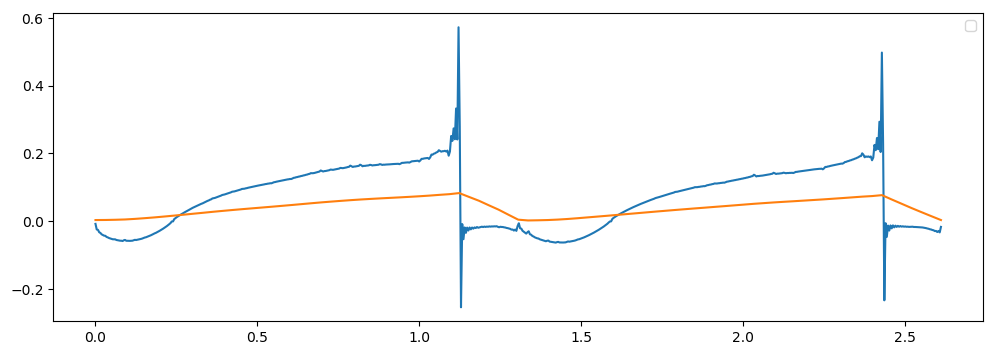

In [22]:
plt.figure(figsize=[12,4.])
#plt.style.use('dark_background')
#plt.style.use('classic')
plt.plot(xint,bed_shear_stress*-100.)
plt.plot(xc, zbed)
plt.legend()

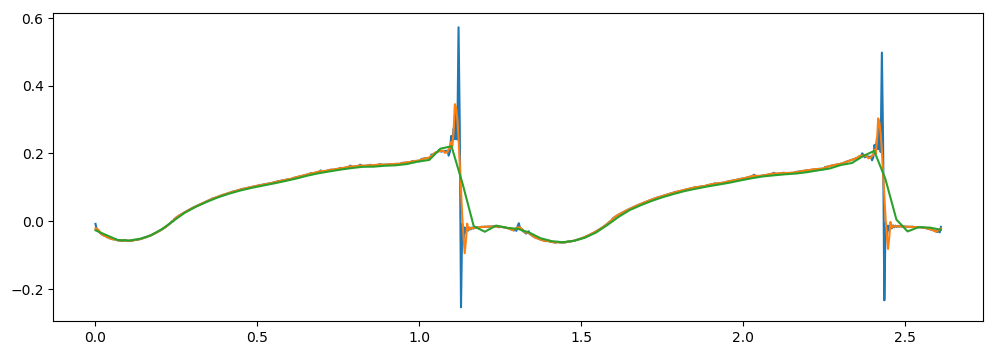

In [94]:
import scipy.signal

plt.figure(figsize=[12,4.])
bed_shear_stress_smoothed_7 = savgol_filter(bed_shear_stress, 7, 2, mode='wrap')
bed_shear_stress_smoothed_11 = savgol_filter(bed_shear_stress, 11, 2, mode='wrap')
bed_shear_stress_smoothed_21 = savgol_filter(bed_shear_stress, 21, 2, mode='wrap')
bed_shear_stress_smoothed_31 = savgol_filter(bed_shear_stress, 31, 2, mode='wrap')

bed_shear_stress_decimated=scipy.signal.decimate(bed_shear_stress,3, ftype="iir")
bed_shear_stress_decimated = savgol_filter(bed_shear_stress_decimated, 13, 3, mode='wrap') 
bed_shear_stress_decimated=scipy.signal.decimate(bed_shear_stress_decimated,3, ftype="iir")

xdec = np.linspace(0, dune_length, len(bed_shear_stress_decimated))
zinterpdec = np.interp(xdec, xc,zbed)


# bed_shear_stress_smoothed_31 = savgol_filter(bed_shear_stress_smoothed_31,41, 2, mode='wrap')

plt.plot(xint,bed_shear_stress*-100.)
plt.plot(xint,bed_shear_stress_smoothed_11*-100.)
#plt.plot(xint,bed_shear_stress_smoothed_21*-100.)
#plt.plot(xint,bed_shear_stress_smoothed_31*-100.)
plt.plot(xdec,bed_shear_stress_decimated*-100.)


## Looking into second derivative

This seems to be where we run into problems - when the second order derivative is positive - moving upwards. 

(1.0, 1.5)

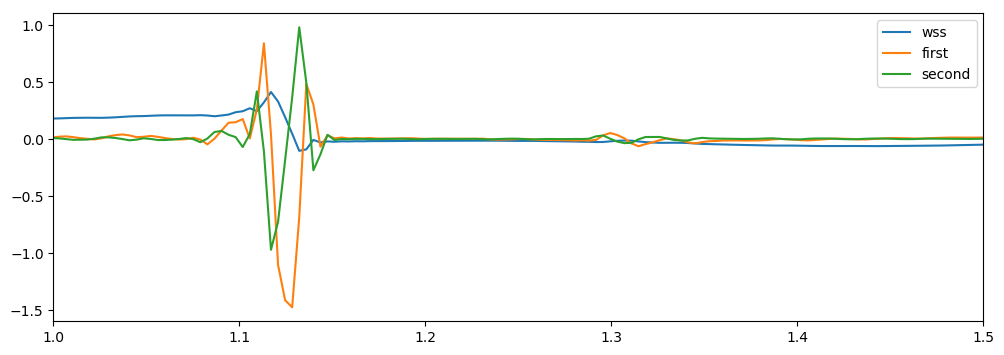

In [118]:
bss = np.array(bed_shear_stress_smoothed_7*-100.)

dtaudx = np.gradient(bss)
d2taudx2 = np.gradient(dtaudx)

plt.figure(figsize=[12,4.])
plt.plot(xint,bss, label='wss')
plt.plot(xint,dtaudx*10., label='first')
plt.plot(xint,d2taudx2*10., label='second')
plt.legend()
plt.xlim([1.0, 1.5])

 Starting simulation....
Number of time steps: 24
Grid dx = 0.003799126637554585
Grid nx = 688
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Max Shear Stress:    5.72415
qbedload shape: (688,)
Max qbedload = 0.00010183128418039933
Shift => 77
Shift => 79
Shift => 80
Shift => 79
Shift => 78
Shift => 77
Shift => 77
Shift => 78
Shift => 78
Shift => 79
Shift => 78
Shift => 77
Shift => 77
Shift => 76
Shift => 76
Shift => 77
Shift => 77
Shift => 77
Shift => 76
Shift => 77
Shift => 75
Shift => 74
Shift => 79
 Done
 ----------------------------


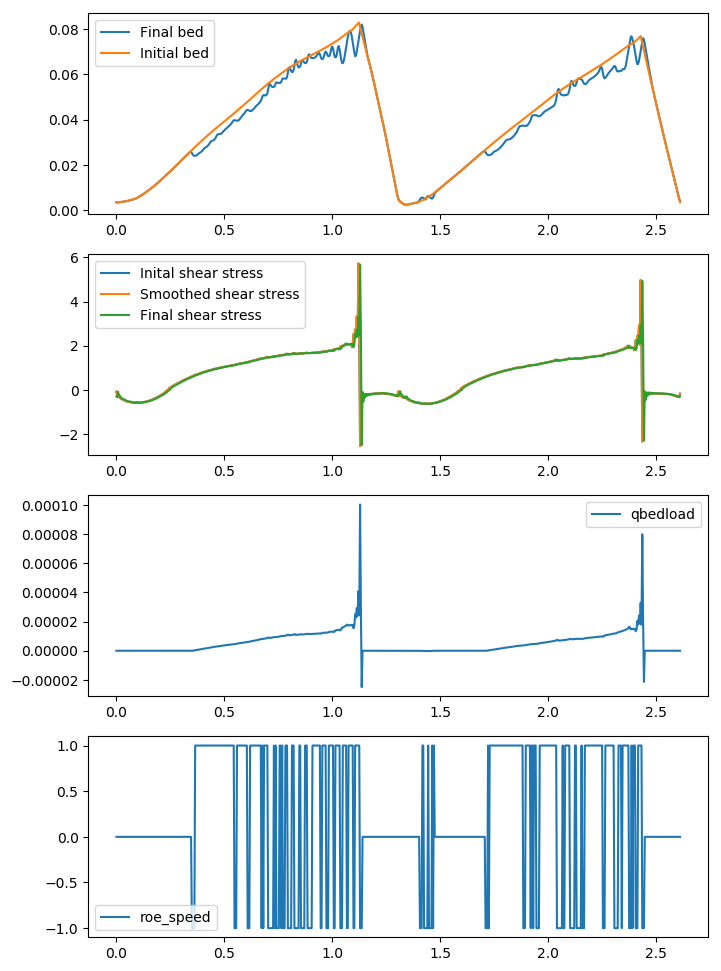

In [134]:
model = wmm.UpwindMorphologicalModel(D50)

#dx = xdec[1]-xdec[0]
#bed_shear_stress_init = bed_shear_stress_decimated.copy() * -1000.

bed_shear_stress_init = bed_shear_stress.copy() * -1000.
dx=xint[1]-xint[0]

model.setup_model(bed_shear_stress_init, zinterp.copy(), xint, dx, useSmoother=True, adjustment_angle=28.)
simulationTime = 120
dt = 5

zc_lske_12cm, qbedload, bedShear, roe_speed, flux = model.run_model(simulationTime, 
                                                             dt=dt, 
                                                             useSlopeAdjust=False)

fig, axs = plt.subplots(4,1, figsize=[8,12])
axs[0].plot(xint, zc_lske_12cm, label='Final bed')
axs[0].plot(xc, zbed, label='Initial bed')
#axs[0].set_xlim([0.075, 0.125])
axs[0].legend(prop=None)

axs[1].plot(xint, bed_shear_stress*-1000., label='Inital shear stress')
axs[1].plot(xint, bed_shear_stress_init, label='Smoothed shear stress')
axs[1].plot(xint, bedShear, label='Final shear stress')
#axs[1].set_xlim([0.075, 0.125])
axs[1].legend()

axs[2].plot(xint, qbedload, label='qbedload')
axs[2].legend()

axs[3].plot(xint, roe_speed, label='roe_speed')
axs[3].legend()

In [96]:
bed_shear_stress_init

array([-0.2681071 , -0.41415243, -0.55554975, -0.57272471, -0.52002387,
       -0.41559521, -0.22974529,  0.00930002,  0.24480671,  0.4229243 ,
        0.57036357,  0.70214175,  0.81205472,  0.90458414,  0.98156445,
        1.04777469,  1.11248609,  1.18230112,  1.25503748,  1.34044023,
        1.41204696,  1.46832372,  1.52107775,  1.56745324,  1.60502046,
        1.61003202,  1.6366962 ,  1.65019462,  1.68793753,  1.76126464,
        1.80717857,  2.13890249,  2.21263536,  1.10471941, -0.14646141,
       -0.31153737, -0.13002811, -0.19475907, -0.22901868, -0.33682255,
       -0.50199288, -0.58870022, -0.62123327, -0.57924272, -0.48680059,
       -0.33315081, -0.11557216,  0.12304513,  0.3252777 ,  0.46959025,
        0.59903272,  0.71063833,  0.80615141,  0.89311231,  0.96111307,
        1.02531948,  1.07997713,  1.13735384,  1.20589772,  1.26881221,
        1.32195002,  1.35453332,  1.38454044,  1.40761018,  1.44915387,
        1.5031983 ,  1.5551766 ,  1.65909053,  1.717798  ,  1.92

In [136]:
np.savetxt('bed_shear_stress_smoothed_31.csv', bed_shear_stress_smoothed_31, delimiter=',')